In [2]:
import jax.numpy as jnp
import jax


In [19]:
def renew(key):
    return jax.random.split(key, 1)[0]

In [67]:
def sample_along_chord(center, vec, cutoff, fn, key,
                       fwd_mult, bwd_mult, 
                       double_iters, resample_iters,
                       doubled=False):
    if double_iters < 0:
        raise ValueError(f"Reached maximum number of doubling steps at mults {fwd_mult}, {bwd_mult}. Consider increasing the initial mults.")
    if resample_iters < 0:
        raise ValueError(f"Reached maximum number of resampling steps at mults {fwd_mult}, {bwd_mult}. Consider decreasing the initial mults.")

    assert fn(center) < cutoff, "center must be below cutoff"

    long_enough = True
    if fn(center + fwd_mult * vec) < cutoff:
        long_enough = False
        fwd_mult *= 2
    if fn(center - bwd_mult * vec) < cutoff:
        long_enough = False
        bwd_mult *= 2
    
    if not long_enough:
        # chord is too short, double the mults and try again
        return sample_along_chord(center, vec, cutoff, fn, key, 
                                  fwd_mult, bwd_mult, 
                                  double_iters - 1, resample_iters, 
                                  doubled=True)
    
    # we've found a long enough chord

    sampled_mult = -bwd_mult + jax.random.uniform(key, ()) * (fwd_mult + bwd_mult)
    key = renew(key)

    sampled_point = center + sampled_mult * vec

    if fn(sampled_point) < cutoff:
        # resampled point is below cutoff, so we're done
        return sampled_point, sampled_mult
    
    # resampled point is above cutoff, so we need to resample

    if not doubled:
        # maybe initial mults were too big?
        fwd_mult /= 2
        bwd_mult /= 2
    
    # either way, resample

    return sample_along_chord(center, vec, cutoff, fn, key, 
                              fwd_mult, bwd_mult, 
                              double_iters, resample_iters - 1, 
                              doubled)


In [68]:
def hit_and_run(center, cutoff, fn, key, n_steps, 
                 fwd_mult=1, bwd_mult=1, 
                 double_iters=10, resample_iters=100):
    
    sampled_points = [center]
    sampled_mults = [0.0]
    for _ in range(n_steps):
        vec = jax.random.normal(key, center.shape)
        key, subkey = jax.random.split(key)
        vec = vec / jnp.linalg.norm(vec)
        sampled_point, sampled_mult = sample_along_chord(center, vec, cutoff, fn, subkey, 
                                                          fwd_mult, bwd_mult, 
                                                          double_iters, resample_iters)
        sampled_points.append(sampled_point)
        sampled_mults.append(sampled_mult)
        center = sampled_point
    return jnp.stack(sampled_points), jnp.stack(sampled_mults)

In [69]:
def test_fn(x):
    return jnp.linalg.norm(x)

In [73]:
key = jax.random.key(0)
dims = 100
center = jnp.array([0.999] + [0.0] * (dims - 1))
cutoff = 1.0
n_steps = 1000
sampled_points, sampled_mults = hit_and_run(center, cutoff, test_fn, key, n_steps)

In [74]:
running_means = jnp.cumsum(sampled_points, axis=0) / jnp.arange(1, n_steps + 2).reshape(-1, 1)

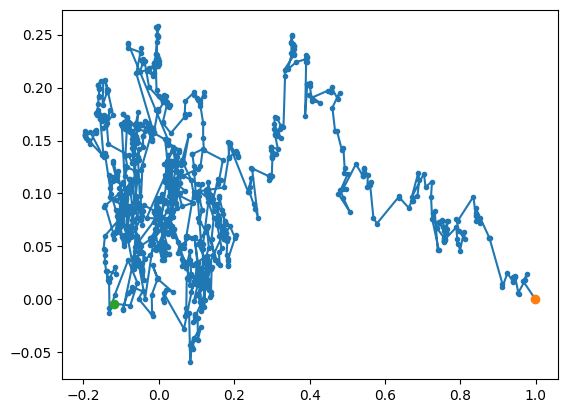

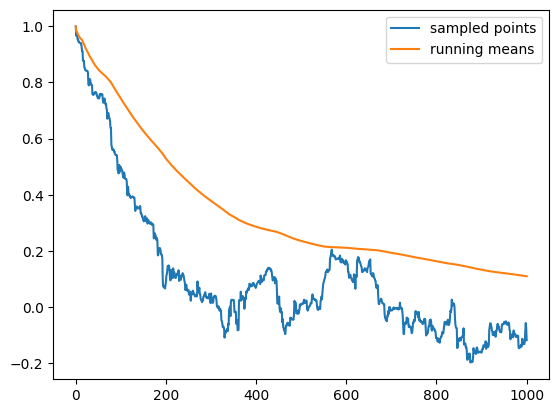

In [75]:
import matplotlib.pyplot as plt
plt.plot(sampled_points[:,0], sampled_points[:,1], '.-')
plt.plot(sampled_points[0,0], sampled_points[0,1], 'o')
plt.plot(sampled_points[-1,0], sampled_points[-1,1], 'o')
plt.show()

plt.plot(sampled_points[:,0], label='sampled points')
plt.plot(running_means[:,0], label='running means')
plt.legend()
plt.show()
